In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from data_jl import GPData
# Sample curves from GPs with varying kernels
batch_size = 8
max_num_context = 400
data_train = GPData(
    batch_size=batch_size, 
    max_num_context=max_num_context
)
curves_train = data_train.generate_curves()

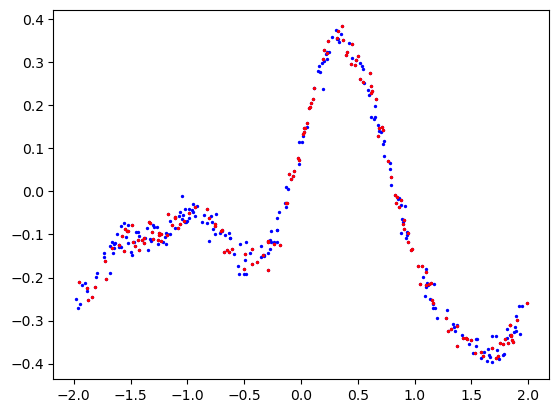

In [3]:
# Get context and targets
context_x_train = curves_train.context_x
context_y_train = curves_train.context_y
target_x_train = curves_train.target_x
target_y_train = curves_train.target_y
d_x = context_x_train.shape[2]
d_y = context_y_train.shape[2]

for i in range(batch_size):
    plt.scatter(target_x_train[i].flatten(), target_y_train[i].flatten(), s=2, c='b')
    plt.scatter(context_x_train[i].flatten(), context_y_train[i].flatten(), s=2, c='r')
    break
plt.show()

In [16]:
def plot_predictive(context_x, context_y, target_x, target_y, pred_y, sigma, save=None):
    '''
    Plot predicted mean and variance given context and targets. 
    '''
    context_x = context_x.cpu()
    context_y = context_y.cpu()
    target_x = target_x.cpu()
    target_y = target_y.cpu()
    pred_y = pred_y.mean.cpu()
    sigma = sigma.cpu()
    # Plot ground truth GP
    plt.plot(target_x.flatten(), target_y.flatten(), 'k:')
    # Plot context points
    plt.scatter(context_x.flatten(), context_y.flatten(), c='k')
    # Plot mean of pred
    plt.plot(target_x.flatten(), pred_y.flatten())
    # Plot variance of pred
    plt.fill_between(
        target_x.flatten(),
        pred_y.flatten() - sigma.flatten(),
        pred_y.flatten() + sigma.flatten(),
        alpha=0.5,
        facecolor='#A6CEE3',
        interpolate=True)
    plt.ylim(-4, 4)
    plt.show()

In [18]:
from np import NeuralProcess
# Training params
n_epochs = int(1e6)
print_after = int(1e4)
plot_after = int(5e4)
train_loss = []

# Data params
batch_size = 16
max_num_context = 100

# Model params
input_dim, output_dim = 1,1
hidden_size = 128
determ_encoder_output_size = [hidden_size] * 2
latent_encoder_output_size = [hidden_size] * 2
num_latents = hidden_size
decoder_output_size = [hidden_size] * 2 + [2 * output_dim]

# Model
x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

model = NeuralProcess(
                x_size = x_dim,
                y_size = y_dim,
                r_size = r_dim,
                z_size = z_dim,
                h_size_dec = h_dim,
                h_size_enc_lat = h_dim,
                h_size_enc_det = h_dim,
                N_h_layers_dec = 3,
                N_xy_to_si_layers = 2,
                N_sc_to_qz_layers = 1,
                N_h_layers_enc_det = 6,
                use_r = False
                ).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


20702


Iteration: 0 Training loss: 0.864561140537262
Iteration: 10000 Training loss: 0.387376070022583
Iteration: 20000 Training loss: 0.31229108572006226
Iteration: 30000 Training loss: 0.3539293706417084


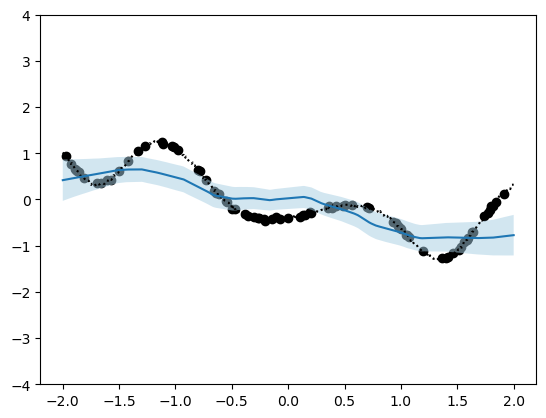

KeyboardInterrupt: 

In [19]:
def loss_function(pred_dist, target_y, posterior, prior):
    # print(pred_dist.mean.shape, target_y.shape)
    # print(posterior.mean.shape, prior.mean.shape)
    num_targets = target_y.size(-2)
    # print(pred_dist)
    log_p = pred_dist.log_prob(target_y).sum(axis=-1)
    # print(f"log_p: {log_p.shape}")
    kl_div = torch.distributions.kl_divergence(
        posterior, prior).sum(axis=-1, keepdim=True)
    loss = -torch.mean(log_p - kl_div / num_targets)
    return loss

model.training = True
for it in range(n_epochs+1):
    optimizer.zero_grad()

    # Sample a batch of datasets (contexts, targets)
    data_train = GPData(
        batch_size=batch_size, max_num_context=max_num_context,)
    curves_train = data_train.generate_curves()
    context_x_train = curves_train.context_x.to(device)
    context_y_train = curves_train.context_y.to(device)
    target_x_train = curves_train.target_x.to(device)
    target_y_train = curves_train.target_y.to(device)

    # Forward
    pred_y, posterior, prior = model(
        context_x_train, context_y_train,
        target_x_train, target_y_train)

    # Calculate loss
    loss = loss_function(pred_y, target_y_train, posterior, prior)

    # Backprop
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    if it % print_after == 0:
        print(f'Iteration: {it} Training loss: {loss.item()}')

    if it % plot_after == 0 and it > 0:
        with torch.no_grad():
            model.training = False
            data_test = GPData(
                batch_size=1, max_num_context=max_num_context, 
                testing=True)
            curves_test = data_test.generate_curves()
            context_x_test = curves_test.context_x.to(device)
            context_y_test = curves_test.context_y.to(device)
            target_x_test = curves_test.target_x.to(device)
            target_y_test = curves_test.target_y.to(device)

            pred_y = model(
                context_x_test, context_y_test, target_x_test)
            plot_predictive(
                context_x_test, context_y_test,
                target_x_test, target_y_test,
                pred_y, pred_y.stddev)
            model.training = True